### This notebook explains the mixed approach of Recommender System - MF(Matrix Factorization) with item similarity based Collaborative Filtering

In [3]:
import pandas as pd
import numpy as np
import sys
# import tensorflow,keras
import os
import sys;
import numpy,sklearn
from pandas import read_csv;
# from keras.layers import Input, Embedding, Flatten, Lambda,Concatenate,Dense,Dropout
# from keras.models import Model
# from keras.initializers import RandomNormal
# from keras.regularizers import l2
# from keras.callbacks import EarlyStopping
# from keras import backend as K
import time
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler
# from keras.callbacks import ModelCheckpoint, EarlyStopping
import datetime
# import fasttext
import codecs
from bs4 import BeautifulSoup
import nltk
import os
import nltk.corpus,nltk.tokenize
from nltk.corpus import stopwords
nltk.download("stopwords")
import re
import string
import matplotlib.pyplot as plt
from pylab import *
# import plotly
# import plotly.graph_objects as go
import sklearn
from IPython import display
import ipywidgets as widgets
import sklearn.metrics as metrics
import operator
from sklearn.metrics.pairwise import cosine_similarity,pairwise_distances 
import implicit
import seaborn as sns
import os
os.chdir('D:/data_science/blog_recommendation/hybrid_recommendation_engine-master/')
import evaluation_func as eval
from pygments import highlight
from pygments.lexers import get_lexer_by_name, get_lexer_for_filename
from pygments.formatters import HtmlFormatter
from IPython.display import display, HTML

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sourish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
data.to_csv('user_item_action.csv',index=False)

### sneak peek of data

   sessionId  userId  itemId action  timeframe eventdate  userID
0         48       2   24764  click       8863  4/9/2016       2
1         48       2   24764  click     496381  4/9/2016       2
2         48       2   24764  click     265216  4/9/2016       2
3         48       2   24764  click     519975  4/9/2016       2
4         48       2   24764  click     456437  4/9/2016       2
unique userId: 9999
unique itemId: 16177
avg. distinct item count per user: 3.216821682168217
avg. distinct user count per item: 1.9883167459974038


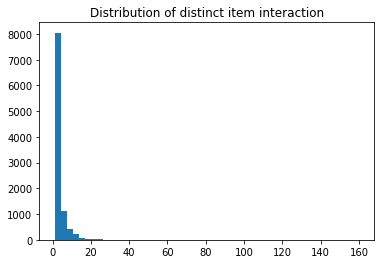

In [6]:
data = pd.read_csv("user_item_action.csv")
data['action']='click' #Adding user action(click) column 
print(data.head(5))
print('unique userId:',len(list(data['userId'].unique())))
print('unique itemId:',len(list(data['itemId'].unique())))
print('avg. distinct item count per user:',data.groupby('userId')['itemId'].nunique().mean())
print('avg. distinct user count per item:',data.groupby('itemId')['userId'].nunique().mean())
user_item_interaction = data.groupby('userId')['itemId'].nunique()
plt.hist(user_item_interaction, bins = 50)
plt.title('Distribution of distinct item interaction')
plt.show()

### For most of the users distinct item interaction is < 5.So we expect extreme sparsity in user-item matrix

### Data Preperation

In [113]:
#Sorting data based on time stamp

data["timeframe"] = pd.to_datetime(pd.to_numeric(data["timeframe"]), unit="s")
data_sort = data.sort_values(by=["timeframe"],ascending=True)
data_sort['month'] = data_sort["timeframe"].dt.month
data_sort['day'] = data_sort["timeframe"].dt.day
data_sort['day'] = data_sort['day'].astype('str')
data_sort['month'] = data_sort['month'].astype('str')
data_sort['month_day'] = data_sort[['month', 'day']].apply(lambda x: ''.join(x), axis=1)
data_sort['day'] = data_sort['month'].astype('str')
data_sort['userId'] = data_sort['userId'].astype('str')
day_sr_no = {}
# Mapping external to internal days
for i in range(len(data_sort)):
    month_day = data_sort['month_day'][i]
    if month_day not in day_sr_no :
        day_sr_no[month_day] = len(day_sr_no)
month_day = list(day_sr_no.keys())
sr_no = list(day_sr_no.values())
day_sr = pd.DataFrame({'month_day':month_day,'day_seq':sr_no})     
data_sort = pd.merge(left=data_sort.reset_index(drop=True),right=day_sr.reset_index(drop=True),how='left',on='month_day')
data_sort.sort_values(["userId",'day_seq'],ascending=True,inplace=True)
data_sort['day_seq'] = data_sort['day_seq'].astype('str')
data_sort['UserID_day'] = data_sort[['userId', 'day_seq']].apply(lambda x: ''.join(x), axis=1)
data_sort[['userId','itemId']] = data_sort[['userId','itemId']].astype('object')
data_sort.drop('timeframe',axis =1).head(5)

,sessionId,userId,itemId,action,eventdate,userID,month,day,month_day,day_seq,UserID_day
2562,172,10,36602,click,2/21/2016,10,1,1,11,0,100
27931,172,10,36602,click,2/21/2016,10,1,1,16,1,101
28730,172,10,10691,click,2/21/2016,10,1,1,16,1,101
23215,172,10,47373,click,2/21/2016,10,1,1,14,2,102
27117,172,10,10858,click,2/21/2016,10,1,1,15,5,105


#### Identifying/Filtering users who appeared more than one days for splitting data into train and validation to simulate A/B  test environment

In [114]:
data_sort_user = data_sort[['userId','day_seq']]
data_sort_user.drop_duplicates(subset=None, keep='first', inplace=True)
user_id_repeat = pd.DataFrame(data_sort_user.groupby('userId').day_seq.nunique())
user_id_repeat['user'] = user_id_repeat.index
user_id_repeat.reset_index(drop=True, inplace = True)
user_id_repeat = user_id_repeat[(user_id_repeat['day_seq']>1)]
data_sort_user = data_sort_user[data_sort_user['userId'].isin(list(user_id_repeat['user']))]

#To get the last day for each user
max_day = data_sort_user.groupby('userId').day_seq.max()
user_id_repeat['max_day'] = max_day.values
user_id_repeat['user_day'] = user_id_repeat[['user', 'max_day']].apply(lambda x: ''.join(x), axis=1)
user_id_repeat.head(5)

c:\users\sourish\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,day_seq,user,max_day,user_day
0,5,10,6,106
1,2,100,6,1006
2,3,1000,7,10007
3,2,10000,7,100007
4,3,10001,7,100017


#### Filtering out data including only repeat users

In [115]:
data_sort_repeat = data_sort[data_sort['userId'].isin(list(user_id_repeat['user']))]
data_sort_repeat.sort_values(["userId",'day_seq'],ascending=True,inplace=True)
data_sort_repeat = data_sort_repeat[["userId",'itemId','action','day_seq','UserID_day']]
data_sort_repeat['day_seq'] = data_sort_repeat['day_seq'].astype('int')
data_sort_repeat.head(5)

c:\users\sourish\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,userId,itemId,action,day_seq,UserID_day
2562,10,36602,click,0,100
27931,10,36602,click,1,101
28730,10,10691,click,1,101
23215,10,47373,click,2,102
27117,10,10858,click,5,105


### train(common users of all but last day) and hold out validation/test samples(common users of last day) split

In [116]:
#Train-test-1 day test
test = data_sort_repeat[data_sort_repeat['UserID_day'].isin(list(user_id_repeat['user_day']))]
train = data_sort_repeat[~data_sort_repeat['UserID_day'].isin(list(user_id_repeat['user_day']))]
print(train.shape)
print(test.shape)

(24930, 5)
(7642, 5)


### MF training data with implicit feedback format(count of clicks)

In [117]:
train[['userId', 'itemId']] = train[['userId', 'itemId']].astype(str)
train['user_item'] = train[['userId', 'itemId']].apply(lambda x: '_'.join(x), axis=1)
training = train[['user_item','action']]
training = pd.DataFrame(pd.pivot_table(training, values='action', index=['user_item'],columns=['action'], aggfunc=np.count_nonzero))
training['user_item'] = training.index
training = pd.DataFrame(np.array(training))
training.columns = ['click', 'user_item']
training.fillna(0,inplace=True)
training['userId'] = training['user_item'].apply(lambda x: str(x).split('_')[0])
training['itemId'] = training['user_item'].apply(lambda x: str(x).split('_')[1])
training.drop('user_item',axis=1,inplace=True)
#training[['UserID', 'itemID']] = training[['UserID', 'itemID']].apply(pd.to_numeric, errors='coerce')
training['userId'] = pd.to_numeric(training['userId'])
training['itemId'] = training['itemId'].astype(int)
training.columns=['click', 'userId', 'itemId']
training.head(3)

c:\users\sourish\anaconda3\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
c:\users\sourish\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,click,userId,itemId
0,2,10000,20024
1,4,10001,109029
2,2,10001,134792


#### Creating hold-out test sample user-item unique interaction

In [118]:
testing = test[['userId', 'itemId']]
testing.drop_duplicates(subset=None, keep='first', inplace=True)
testing.head(3)

c:\users\sourish\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,userId,itemId
15115,10,10263
14104,100,3717
15547,100,3655


### For evaluation purpose keeping only users who are present both in training and validation(testing)

In [119]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 
final_users = intersection(list(train['userId'].unique()),list(test['userId'].unique()))
testing = testing[testing['userId'].isin(list(final_users))]
training = training[training['userId'].isin(list(final_users))]
print('unique_user in training:',len(list(training['userId'].unique())),'and unique_user in testing:',len(list(testing['userId'].unique())))

unique_user in training: 5352 and unique_user in testing: 5352


### Although we loss a significant no of users now the data is suitable for offline performance assessment

In [120]:
testing[['userId', 'itemId']] = testing[['userId', 'itemId']].apply(pd.to_numeric)
training[['userId', 'itemId']] = training[['userId', 'itemId']].apply(pd.to_numeric)
testing.sort_values(['userId','itemId'],axis=0,inplace=True)
training.sort_values(['userId','itemId'],axis=0,inplace=True)

In [121]:
## Mapping external to internal user and item Ids 
user_dict = {}
for i,user in enumerate(sorted(training.userId.unique())):
    user_dict[user] = i 
    
item_dict = {}
for i,item in enumerate(training.itemId.unique()):
    item_dict[item] = i    

In [122]:
training['userId'] = [user_dict[i] for i in training.userId]
testing['userId'] = [user_dict[i] for i in testing.userId]
training['score'] = training.click.values  #Currently using the simple formula,will be changed based on relative importance

### Preparing user-item sparse matrix for matrix factorization

In [136]:
item_user_matrix = pd.DataFrame(training.pivot(index='userId', columns='itemId', values='score'))
item_user_matrix.fillna(0,inplace=True)
print('sparsity in data:',(1.0 - (np.count_nonzero(item_user_matrix) / float(item_user_matrix.size))))

sparsity in data: 0.9996901198420426


### Let's see how the algorithms works in this super sparse data. First we check the match rate as screening before further assessment   

In [137]:
# item_user_matrix = pd.DataFrame(training.pivot(index='userId', columns='itemId', values='score'))
# item_user_matrix.fillna(0.000001,inplace=True) #Instead of  0 Replacing with a very small value to avoid possible NaN error during computation
item_dict = {}
for i,item in enumerate(item_user_matrix.columns):
    item_dict[item] = i
item_user_matrix_sparse = sparse.csr_matrix(np.array(item_user_matrix))
item_user_matrix_sparse.shape    

(5352, 12620)

In [125]:
#Reversing user-dict to get the userIds back

user_rev_dict = {v: k for k, v in user_dict.items()}
user_id = pd.Series(list(user_rev_dict.values())).values
user_id = user_id[:,np.newaxis]
user_id = user_id.reshape((len(user_id)))
user_id

array([     2,      3,      4, ..., 214354, 231673, 241688], dtype=int64)

### Popularity based- non personalized.Will recommend every user fixed 20 items based on popularity

In [261]:
pop_20 = list(np.argsort(-np.sum(item_user_matrix_sparse.toarray(),axis=0))[:20])
print(pop_20)

[2660, 1664, 5162, 2463, 4957, 5324, 1846, 5350, 2174, 5096, 12585, 154, 5303, 5179, 1674, 5174, 255, 1443, 923, 766]


#### Match-rate actual vs. predicted

In [262]:
#Actual

testing[['userId']] = testing[['userId']].apply(pd.to_numeric, errors='coerce')
users = []
items = []
for u,i in enumerate(np.unique(testing['userId'])):
    user = user_rev_dict[u]
    users.append(user)
    l = list(testing[testing['userId'] == i]['itemId'])
    item = [item_dict[x] if x in item_dict.keys() else 9999 for x in l]
    items.append(item)
test_reco = pd.DataFrame({'user_id':user_id,'items':items})

#Predicted pop_20

NN_pop = [pop_20 for i in range(len(user_id))]
recommended_pop = pd.DataFrame({'user_id':user_id,'items':NN_pop})

In [263]:
#Calculating actual match rate(atleast one product match) between recommended vs. actual

cnt = 0
match = []
for i in range(recommended_pop.shape[0]):
    l1=recommended_pop['items'][i]
    l2=test_reco['items'][i]
    if len(intersection(l1,l2)) > 0:
        cnt+=1
        match.append(1)
    else:
        match.append(0)
print('match rate:',cnt/recommended_pop.shape[0])   

match rate: 0.02466367713004484


### Only 2.47% match.Popularity based approach is a poor fit for this data

### item-item CF(Cosine similarity)

In [268]:
def recommend_items_to_users_cosine(item_user_matrix_sparse,metric='cosine',top_items=20):
    item_similarity = pairwise_distances(item_user_matrix.T, metric=metric)
    cos_similarity = np.array(item_user_matrix_sparse.dot(item_similarity))/ np.array([np.abs(item_similarity).sum(axis=1)])
    nn = np.argsort(-cos_similarity)[:, :top_items]
    return nn
nn = recommend_items_to_users_cosine(item_user_matrix_sparse, metric='cosine', top_items=20)
print(nn.shape)
NN_CF = [nn[i] for i in range(len(nn))]
recommended_CF = pd.DataFrame({'user_id':user_id,'items':NN_CF})

(5352, 20)


#### Match rate

In [269]:
#Calculating actual match rate(atleast one product match) between recommended vs. actual

cnt = 0
match = []
for i in range(recommended_CF.shape[0]):
    l1=recommended_CF['items'][i]
    l2=test_reco['items'][i]
    if len(intersection(l1,l2)) > 0:
        cnt+=1
        match.append(1)
    else:
        match.append(0)
print('match rate:',cnt/recommended_CF.shape[0]) 

match rate: 0.0476457399103139


### Better with 4.76% match rate, almost 100% improvement. However CF alone not suitable to handle this sparsity and massive product universe. Let's try some ML based approach

### Pure MF-ALS

In [241]:
model = implicit.als.AlternatingLeastSquares(factors=32, regularization=0.1, iterations=100)
alpha = 15
model.fit((item_user_matrix_sparse * alpha_val).astype('double'))

100%|█████████████████████████████████████████████████████████████████████████████| 100.0/100 [00:00<00:00, 104.82it/s]


In [242]:
def recommend_items_to_users_MF(model,top_items=20):
    score = np.dot(model.item_factors,model.user_factors.T) 
    nn = np.argsort(-score)[:, :top_items]
    return nn

In [278]:
#Calculating actual match rate(atleast one product match) between recommended vs. actual
nn_mf = recommend_items_to_users_MF(model,top_items=20)
print(nn.shape)
NN_MF = [nn_mf[i] for i in range(len(nn_mf))]
recommended_MF = pd.DataFrame({'user_id':user_id,'items':NN_MF})
cnt = 0
match = []
for i in range(recommended_MF.shape[0]):
    l1=recommended_MF['items'][i]
    l2=test_reco['items'][i]
    if len(intersection(l1,l2)) > 0:
        cnt+=1
        match.append(1)
    else:
        match.append(0)
print('match rate:',cnt/recommended_MF.shape[0]) 

(5352, 20)
match rate: 0.3678998505231689


### Drastic improvement with 36.8% match rate, almost 700% improvement over pure CF based recommendation.Keeping in mind only 20 product pick out of massive(12620) product space it's a great start. 

### MF coupled with cosine similarity.Let's explore wheather we can further improve the result mixing MF and CF.

In [255]:
alpha = 15
user_vecs, item_vecs = implicit.alternating_least_squares(
    (item_user_matrix_sparse*alpha).astype('double'), 
     factors=32, 
     regularization = 0.1, 
     iterations = 100)

print(user_vecs.shape, item_vecs.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 100.0/100 [00:00<00:00, 107.07it/s]


(5352, 32) (12620, 32)


#### Calculate cosine similarity between respective user vector(embeddings numbers- 1 X32) and item-item embeddings(12620 X latent vector dimension).The matrix dot product will pick up similarity values(12620 X 1) for all products.
#### Sorting the similarity values to arrive to get top n items(20) for respective user.

In [280]:
def recommend_items_to_users_hybrid(indexes, users_vec, items_vec, top_items=20):
    cos_similarity = cosine_similarity(        #cosine similarity between product pairs for user vector
        users_vec[indexes, :], items_vec)
    nn = np.argsort(-cos_similarity)[:, :top_items]
    return nn

#### product recommendation basis on MF + item similarity based CF approach

In [281]:
indexes = list(range(user_vecs.shape[0]))
#indexes = list[0]
nn_hybrid = recommend_items_to_users_hybrid(indexes, user_vecs, item_vecs)
print(nn.shape, nn[:2, :])
NN_hybrid = [list(nn_hybrid[i]) for i in range(len(nn_hybrid))]
recommended_hybrid = pd.DataFrame({'user_id':user_id,'items':NN_hybrid})

(5352, 20) [[10729  8264   904  9697 11170 11725 10415  9419 11898  8720 10193  9142
  10191 11695 11877  6102  6803 10866  1328  8201]
 [11576  5668   469  6980   904 10651 10654 10574  8894  8880 12204  1328
  10704  3918 10713  8888 12185  8990  5740 12124]]


### Sneak-peak between recommended vs. actual 

In [259]:
print(test_reco.head(10))
recommended_hybrid.head(10)

   user_id               items
0        2              [3669]
1        3              [5372]
2        4              [2092]
3        6              [8826]
4        7        [1498, 5875]
5        9              [4889]
6       10              [1978]
7       14              [2061]
8       16              [9999]
9       20  [1061, 1234, 5324]


,user_id,items
0,2,"[3669, 10172, 1086, 5246, 1170, 3246, 6161, 32..."
1,3,"[9855, 5678, 5311, 12083, 7392, 12071, 12051, ..."
2,4,"[1129, 8390, 9481, 2092, 1356, 2067, 1978, 435..."
3,6,"[1517, 3395, 11111, 6949, 2097, 8989, 7736, 19..."
4,7,"[3427, 7295, 634, 8249, 7307, 2674, 5198, 990,..."
5,9,"[8552, 3860, 10566, 2256, 4103, 6563, 5594, 73..."
6,10,"[9481, 8390, 2092, 1356, 5491, 8517, 2067, 435..."
7,14,"[1369, 7103, 12560, 5361, 8354, 1583, 6520, 23..."
8,16,"[8686, 7186, 8812, 5911, 11076, 9095, 7557, 10..."
9,20,"[5394, 999, 7962, 1097, 2459, 2572, 2458, 2750..."


### Apparently can see a high match-rate(TP) and calculate the match rate 

In [260]:
#Calculating actual match rate(atleast one product match) between recommended vs. actual

cnt = 0
match = []
for i in range(recommended_hybrid.shape[0]):
    l1=recommended_hybrid['items'][i]
    l2=test_reco['items'][i]
    if len(intersection(l1,l2)) > 0:
        cnt+=1
        match.append(1)
    else:
        match.append(0)
print(cnt/recommended_hybrid.shape[0])    

0.40115844544095663


### with the hybrid approach we achieve 40.12% match rate, almost 9% improvement over pure MF based recommendation.Although most of the intelligence lies in creating embeddings during MF process,CF(further cosine similarity based filtering of product pairs for each user) adds significant extra lift to the recommendation engine. 

### Comparing overall performance with pure MF based and hybrid recommendation

#### Let's explore the custom functions to calculate performance metrics

In [337]:
template = """<style>
{}
</style>
{}
"""
def show_file(filename):
    lexer = get_lexer_for_filename(filename)
    formatter = HtmlFormatter(cssclass='pygments')
    
    with open(filename) as f:
        code = f.read()
    
    html_code = highlight(code, lexer, formatter)
    css = formatter.get_style_defs('.pygments')
    
    html = template.format(css, html_code)
    
    display(HTML(html))
    
show_file('evaluation_func.py')

#### Let's explore match indicator(0/1) for MF vs. Hybrid approach. First and second element in each tuple in field 'match' is indicator for MF and hybrid resp.

In [299]:
reco_df = pd.DataFrame({'user_id':user_id,'items_act':items,'item_rec_mf':list(nn_mf),'item_rec_hybrid':list(nn_hybrid)})
reco_df['match'] = reco_df.apply(lambda row: eval.check_one_match(row[1], row[2],row[3],top_n=20), axis=1)  
reco_df.head(5)

,user_id,items_act,item_rec_mf,item_rec_hybrid,match
0,2,[3669],"[3669, 2701, 5350, 5394, 1086, 2660, 6183, 251...","[3669, 10172, 1086, 5246, 1170, 3246, 6161, 32...","(1, 1)"
1,3,[5372],"[70, 1781, 1779, 2615, 6534, 4479, 6269, 4226,...","[9855, 5678, 5311, 12083, 7392, 12071, 12051, ...","(0, 1)"
2,4,[2092],"[2092, 2067, 948, 6573, 5491, 4830, 10782, 197...","[1129, 8390, 9481, 2092, 1356, 2067, 1978, 435...","(1, 1)"
3,6,[8826],"[4886, 3601, 5025, 10897, 4971, 3124, 8660, 53...","[1517, 3395, 11111, 6949, 2097, 8989, 7736, 19...","(0, 0)"
4,7,"[1498, 5875]","[5179, 4802, 2432, 1019, 5260, 1016, 5198, 516...","[3427, 7295, 634, 8249, 7307, 2674, 5198, 990,...","(0, 0)"


#### For every metric field(eg. auc) first and second element in each tuple is value for MF and hybrid approach resp for each user.¶

In [311]:
#Performance metric dataset 
reco_df['u_id'] = reco_df.index
# measures = reco_df.apply(lambda row: get_performance_metrics(row[5],row[1], user_vecs,item_vecs,top_nn=20), axis=1)
reco_df['score_mf'] = [i[8].reshape(-1) for i in measures]
reco_df['score_hybrid'] = [i[9].reshape(-1) for i in measures]
reco_df['auc'] = [(i[0],i[1]) for i in measures]
reco_df['MRR'] = [(i[2],i[3]) for i in measures]
reco_df['MAP'] = [(i[4],i[5]) for i in measures]
reco_df['NDCG'] = [(i[6],i[7]) for i in measures]
reco_df.head(5)

,user_id,items_act,item_rec_mf,item_rec_hybrid,match,u_id,score_mf,score_hybrid,auc,MRR,MAP,NDCG
0,2,[3669],"[3669, 2701, 5350, 5394, 1086, 2660, 6183, 251...","[3669, 10172, 1086, 5246, 1170, 3246, 6161, 32...","(1, 1)",0,"[-0.052490182, 0.0031282501, -0.020766765, 0.0...","[-0.15278631, 0.028971292, -0.16377506, 0.2410...","(0.9992471669704415, 0.9992471669704415)","(0.05, 0.05)","(0.5, 1.0)","(1.0, 1.0)"
1,3,[5372],"[70, 1781, 1779, 2615, 6534, 4479, 6269, 4226,...","[9855, 5678, 5311, 12083, 7392, 12071, 12051, ...","(0, 1)",1,"[-0.11705529, -0.025777327, 0.013785686, 0.005...","[-0.18034473, -0.12636015, 0.05754578, 0.01197...","(0.499207544179412, 0.9992471669704415)","(0.0, 0.05)","(0.0, 0.05555555555555555)","(0.0, 0.23981246656813146)"
2,4,[2092],"[2092, 2067, 948, 6573, 5491, 4830, 10782, 197...","[1129, 8390, 9481, 2092, 1356, 2067, 1978, 435...","(1, 1)",2,"[0.1269677, 0.0069081597, -0.004788185, 0.0603...","[0.405068, 0.07012245, -0.04138836, 0.29055303...","(0.9992471669704415, 0.9992471669704415)","(0.05, 0.05)","(1.0, 0.25)","(1.0, 0.5)"
3,6,[8826],"[4886, 3601, 5025, 10897, 4971, 3124, 8660, 53...","[1517, 3395, 11111, 6949, 2097, 8989, 7736, 19...","(0, 0)",3,"[0.04317532, 0.0029751188, -0.014475862, 0.020...","[0.085892364, 0.018831424, -0.07802541, 0.0604...","(0.499207544179412, 0.499207544179412)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"
4,7,"[1498, 5875]","[5179, 4802, 2432, 1019, 5260, 1016, 5198, 516...","[3427, 7295, 634, 8249, 7307, 2674, 5198, 990,...","(0, 0)",4,"[-0.006367788, 0.017509054, 0.005814514, -0.00...","[-0.03171058, 0.27742028, 0.078451574, -0.0073...","(0.49920748137581233, 0.49920748137581233)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)"


#### Finally we get the comparative performance metric figure for MF vs. Hybrid by averaging each metric across all users. Here it's comparison between two best solution, however for other approaches metrics can be calculated similarly. 

In [313]:
#Performance

match_mf = [i[0] for i in reco_df['match']]
match_hybrid = [i[1] for i in reco_df['match']]
auc_mf = [i[0] for i in reco_df['auc']]
auc_hybrid = [i[1] for i in reco_df['auc']]
MAP_mf = [i[0] for i in reco_df['MAP']]
MAP_hybrid = [i[1] for i in reco_df['MAP']]
MRR_mf = [i[0] for i in reco_df['MRR']]
MRR_hybrid = [i[1] for i in reco_df['MRR']]
NDCG_mf = [i[0] for i in reco_df['NDCG']]
NDCG_hybrid = [i[1] for i in reco_df['NDCG']]
print('match rate/TP for MF:', np.mean(match)) 
print('match rate/TP for hybrid:', np.mean(match_hybrid)) 
print('AUC for MF:', np.mean(auc_mf)) 
print('AUC for hybrid:', np.mean(auc_hybrid)) 
print('MAP for MF:', np.mean(MAP_mf)) 
print('MAP for hybrid:', np.mean(MAP_hybrid)) 
print('MRR for MF:', np.mean(MRR_mf)) 
print('MRR for hybrid:', np.mean(MRR_hybrid))
print('NDCG for MF:', np.mean(MRR_mf)) 
print('NDCG for hybrid:', np.mean(MRR_hybrid))

match rate/TP for MF: 0.3678998505231689
match rate/TP for hybrid: 0.40115844544095663
AUC for MF: 0.6336362538668119
AUC for hybrid: 0.6747993938671657
MAP for MF: 0.11373469839364617
MAP for hybrid: 0.16712752000049622
MRR for MF: 0.01783445440956652
MRR for hybrid: 0.023252989536621825
NDCG for MF: 0.01783445440956652
NDCG for hybrid: 0.023252989536621825


### Earlier we already explored match rate comparison for pure MF vs. MF-CF approach. Here we see the direction consistency for other evaluation metric as well. In final hybrid solution we achieve average AUC of 0.675. Contrary to binary classification(with only 2 options), here with massive product space of 12620 options and tiny user space(only 5352 users), it's quite a decent result for the business.

## Thank You